# Multimodal Solar Radiation Forecasting 多模态太阳辐射预测

This code demonstrates ultra-short-term forecasting (10 minutes) using meteorological data and all-sky image data. The data originates from Hunan University's Building Smart Energy Laboratory (BEST). Two months of data were used for training, with 20 days for validation and 20 days for testing.
本代码展示了使用气象数据和全天空图像数据进行超短期预测（10分钟）。数据来源于湖南大学建筑智慧能源实验室（BEST），使用两个月进行训练，20天验证，20天测试。

#  Import library

In [3]:
import os
import shutil
import pandas as pd
import numpy as np
from tensorflow import keras
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf

# Load the data and visualization 数据集导入及可视化

In [ ]:
# Loading the meteorological data
texts = pd.read_csv(r"D:\BEST气象变量数据集\气象变量.csv")
# Loading the meteorological data
img_path = 'D:/ASI(2min)-daytime-64resolution'
images = []
progress_bar = tqdm(total=len(os.listdir(img_path)))
for image_path in os.listdir(img_path):
    fulldir = os.path.join(img_path, image_path)
    image =cv2.imread(fulldir)
    images.append(np.array(image))
    progress_bar.update(1)  # update the progress bar for each image processed
# Close the progress bar after processing all images
progress_bar.close()

100%|████████████████████████████████████████████████████████████████████████████| 77709/77709 [23:53<00:00, 54.21it/s]


In [15]:
texts1 = texts.loc[:,texts.columns.isin(["水平辐射-太阳辐射","温湿度传感器-室外-湿度","温湿度传感器-室外-温度","zenith","晴空辐射","晴空因子"])]
texts1

,水平辐射-太阳辐射,温湿度传感器-室外-湿度,温湿度传感器-室外-温度,zenith,晴空辐射,晴空因子
0,73.799990,100.0000,24.4817,79.731484,131,0.563359
1,74.879980,100.0000,24.4784,79.317187,138,0.542609
2,78.160000,100.0000,24.3881,78.902349,145,0.539034
3,79.280000,100.0000,24.3164,78.486978,153,0.518170
4,79.280000,100.0000,24.4664,78.071080,160,0.495500
...,...,...,...,...,...,...
77704,83.900024,33.7830,25.6807,77.909739,175,0.479429
77705,80.000015,34.7466,25.4409,78.343283,167,0.479042
77706,76.599976,36.9137,25.0923,78.777163,159,0.481761
77707,75.000000,38.1754,24.8678,79.211370,151,0.496689


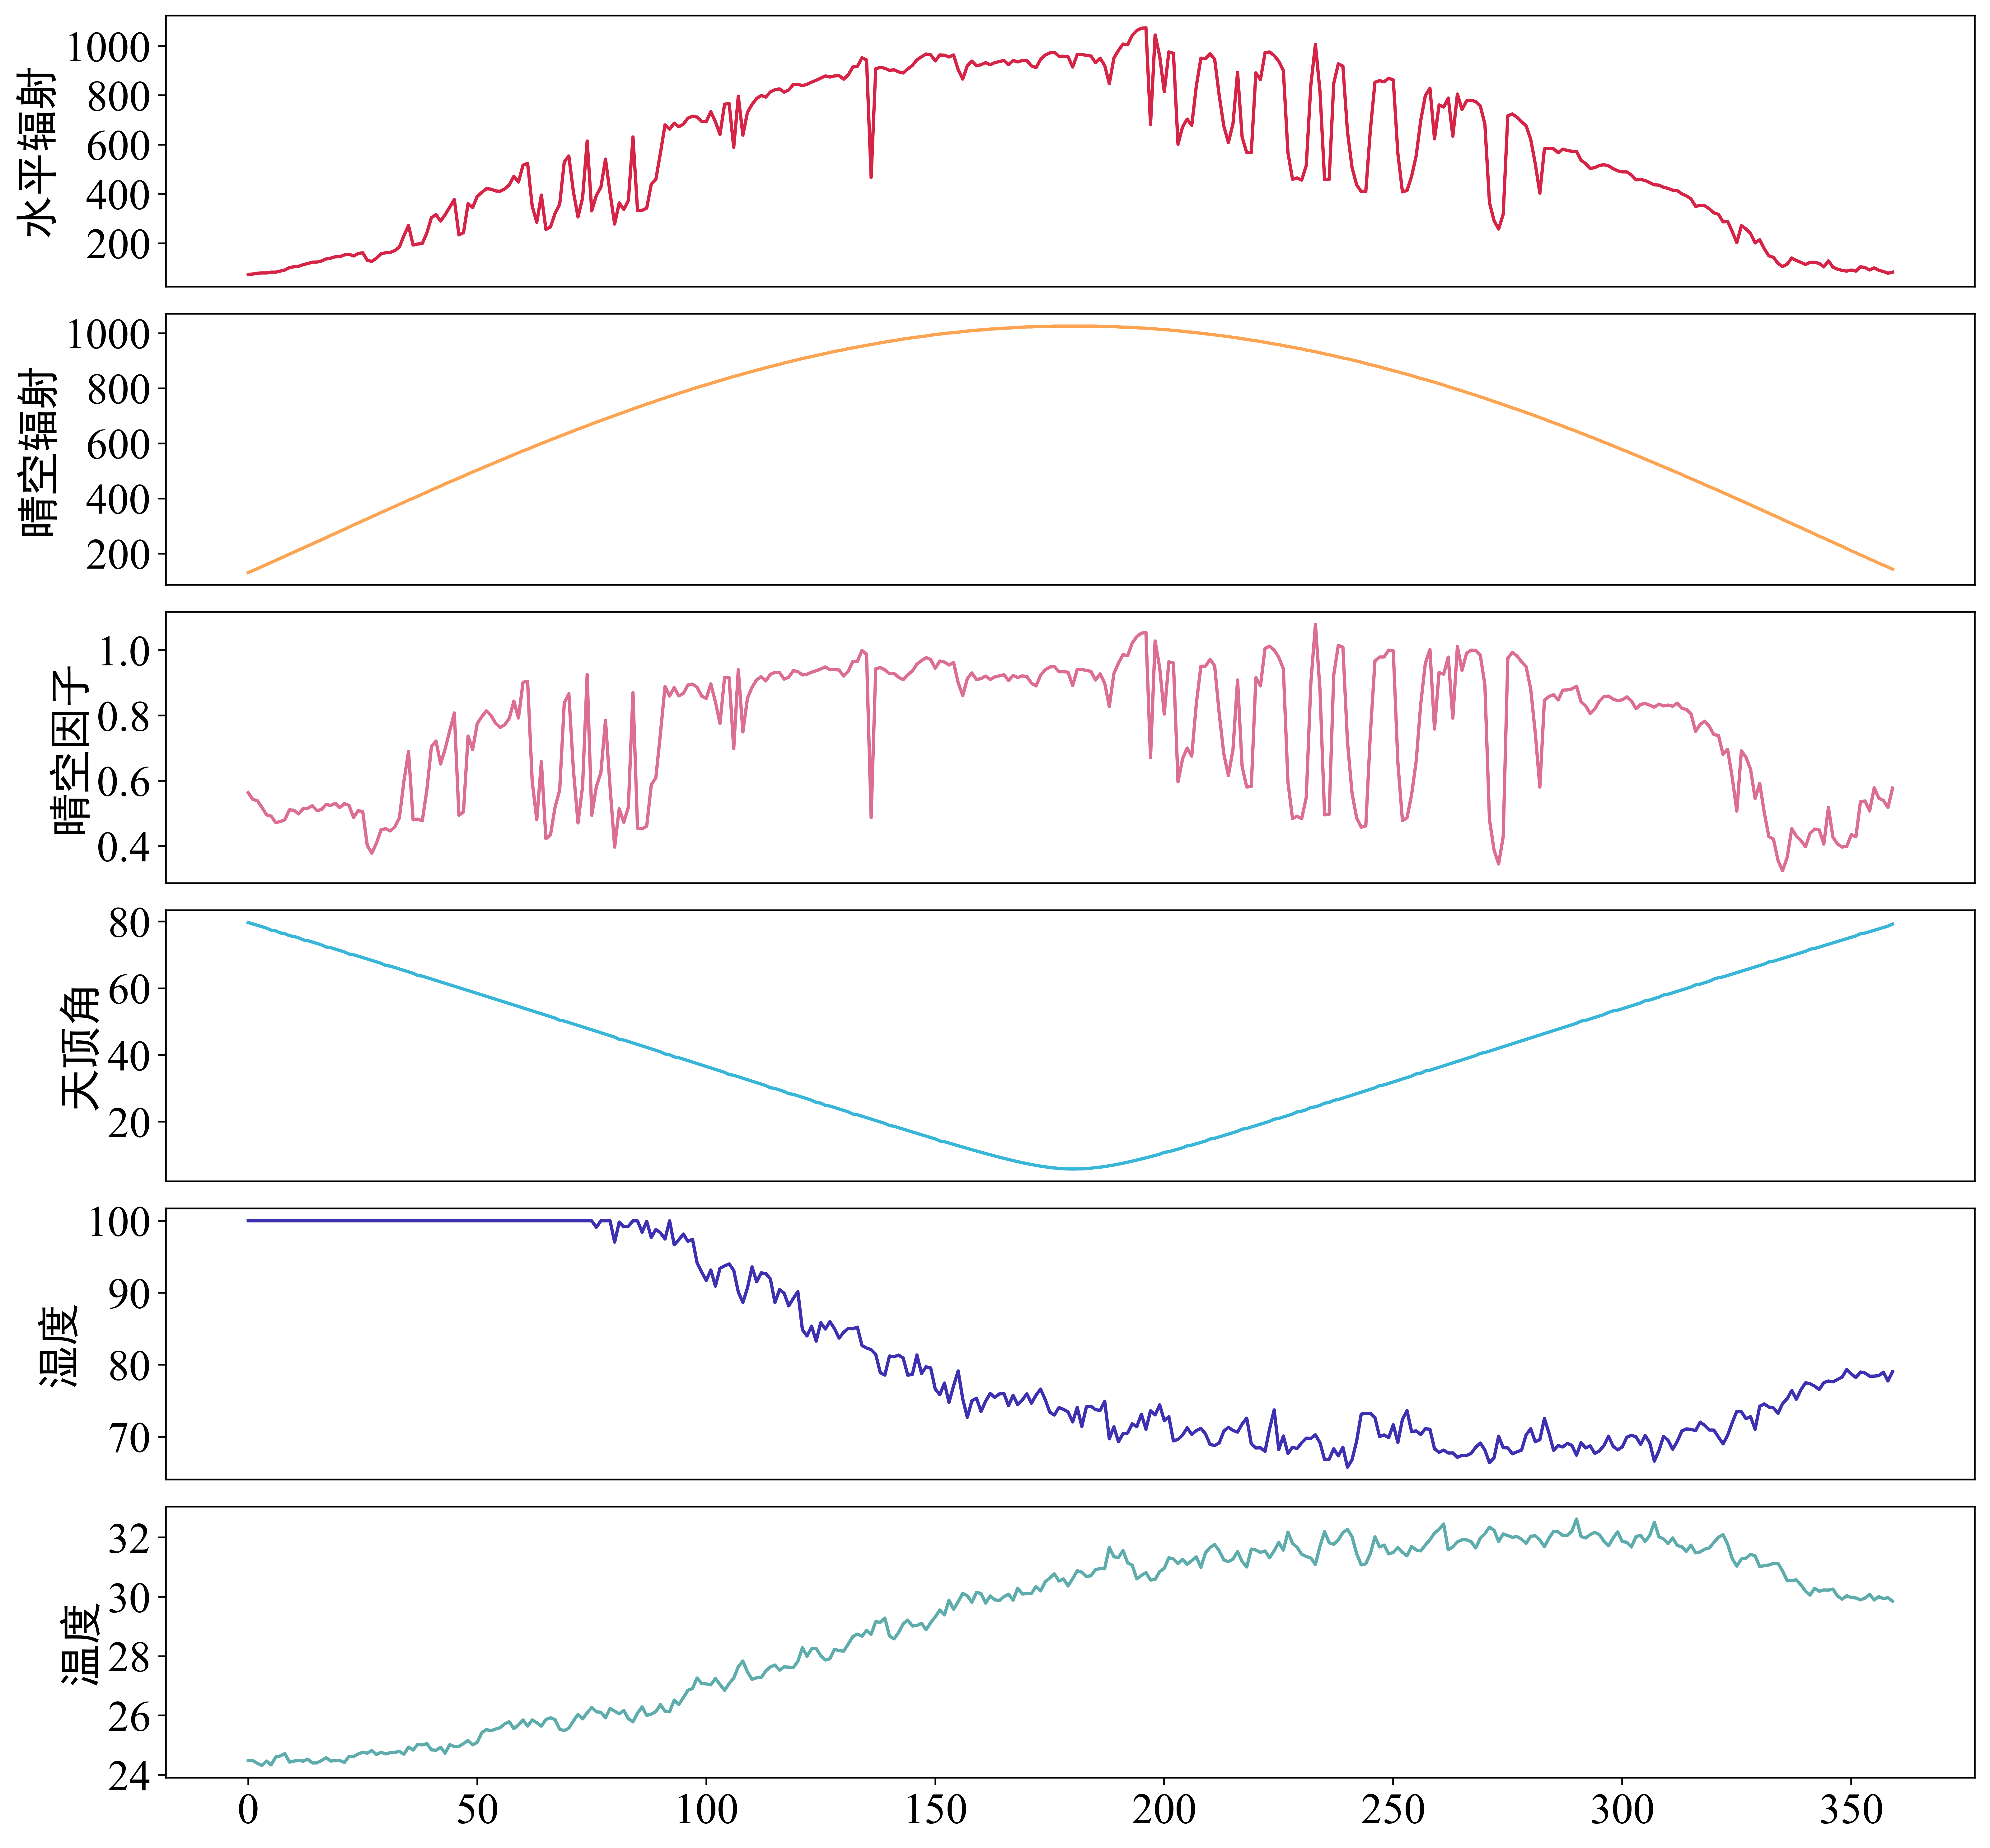

In [11]:
plt.figure(figsize=(15,15),dpi=500)
plt.subplots_adjust(hspace=0.1)
plt.rcParams['axes.facecolor']='white'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.subplot(6,1,1)
plt.plot(texts1["水平辐射-太阳辐射"][:360], "#D62447")
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(alpha=0)
plt.tick_params(axis='x', width=0, labelsize=20)
plt.ylabel("水平辐射",fontsize=20)
plt.subplot(6,1,2)
plt.plot(texts1["晴空辐射"][:360], '#FDA453')
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(alpha=0)
plt.tick_params(axis='x', width=0, labelsize=20)
plt.ylabel("晴空辐射",fontsize=20)
plt.subplot(6,1,3)
plt.plot(texts1["晴空因子"][:360], '#DC6D93')
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(alpha=0)
plt.tick_params(axis='x', width=0, labelsize=20)
plt.ylabel("晴空因子",fontsize=20)
plt.subplot(6,1,4)
plt.plot(texts1["zenith"][:360], '#37B6D8')
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(alpha=0)
plt.tick_params(axis='x', width=0, labelsize=20)
plt.ylabel("天顶角",fontsize=20)
plt.subplot(6,1,5)
plt.plot(texts1["温湿度传感器-室外-湿度"][:360], '#3D31B2')
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(alpha=0)
plt.tick_params(axis='x', width=0, labelsize=20)
plt.ylabel("湿度",fontsize=20)
plt.subplot(6,1,6)
plt.plot(texts1["温湿度传感器-室外-温度"][:360], '#5FACAD')
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.ylabel("温度",fontsize=20)
plt.locator_params(axis='x', nbins=10)

# Pre-process raw data 数据预处理

In [ ]:
# Text data normalization
# Text normalization is a crucial preprocessing step in natural language processing (NLP). 
# It transforms text into a canonical (standard) form, 
# reducing variations and inconsistencies that can hinder analysis and model performance.
texts1 = texts1.astype(np.float32)
file_max = texts1[:21502].max(axis=0)
file_min = texts1[:21502].min(axis=0)
texts1 = (texts1 - file_min) / (file_max - file_min)

## 测试集晴空辐射序列构建 

在进行模型评估时，由于每个模型的输出为多步的晴空因子预测值，若要获得多步太阳辐射预测值，需要乘以对应时刻的晴空辐射，这里通过将数据预处理部分y_test的变量从水平辐射改为晴空辐射进行晴空辐射序列的构建

In [29]:
#构建时序数据
# 定义历史时间步数
history_steps = 5

# 构建时序数据
text_sequences = []
image_sequences = []
target_text = []
for i in range(history_steps,34592):
    text_sequence = texts1.loc[i-history_steps:i-1]
    image_sequence = images[i-history_steps:i]
    target = texts1.loc[i:i+history_steps-1,"晴空辐射"]
    text_sequences.append(text_sequence)
    image_sequences.append(image_sequence)
    target_text.append(target)

text_sequences = np.array(text_sequences)
image_sequences = np.array(image_sequences)
target_text = np.array(target_text)

In [30]:
y_test = target_text[28213:]
y_test=y_test.astype(np.float32)

In [31]:
xtest=pd.DataFrame(y_test)
xtest = xtest* (file_max[4]-file_min[4])+file_min[4]
xtest

,0,1,2,3,4
0,172.0,180.0,188.0,196.0,204.0
1,180.0,188.0,196.0,204.0,212.0
2,188.0,196.0,204.0,212.0,220.0
3,196.0,204.0,212.0,220.0,228.0
4,204.0,212.0,220.0,228.0,236.0
...,...,...,...,...,...
6369,196.0,188.0,180.0,172.0,164.0
6370,188.0,180.0,172.0,164.0,156.0
6371,180.0,172.0,164.0,156.0,148.0
6372,172.0,164.0,156.0,148.0,140.0


## 测试集水平总辐射序列构建 

由于最终评估的是水平总辐射的结果，因此在这里构建水平总辐射的真实值序列

In [ ]:
#构建时序数据
# 定义历史时间步数
history_steps = 5

# 构建时序数据
text_sequences = []
image_sequences = []
target_text = []
for i in range(history_steps,34592):
    text_sequence = texts1.loc[i-history_steps:i-1]
    image_sequence = images[i-history_steps:i]
    target = texts1.loc[i:i+history_steps-1,"水平辐射-太阳辐射"]
    text_sequences.append(text_sequence)
    image_sequences.append(image_sequence)
    target_text.append(target)

text_sequences = np.array(text_sequences)
image_sequences = np.array(image_sequences)
target_text = np.array(target_text)

In [ ]:
y_test = target_text[28213:]
y_test=y_test.astype(np.float32)

In [ ]:
#真实值反归一化
ytest_=pd.DataFrame(y_test)
ytest_ = ytest_* (file_max[0]-file_min[0])+file_min[0]
ytest_

## 输入序列输出序列构建 

本案例的模型初步预测结果为晴空因子，然后再乘以对应时刻的晴空辐射得到预测的总辐射，因此这里将晴空因子作为模型的输出变量y

In [51]:
#构建时序数据
# 定义历史时间步数
history_steps = 5

# 构建时序数据
text_sequences = []
image_sequences = []
target_text = []
for i in range(history_steps,34592):
    text_sequence = texts1.loc[i-history_steps:i-1]
    image_sequence = images[i-history_steps:i]
    target = texts1.loc[i:i+history_steps-1,"晴空因子"]
    text_sequences.append(text_sequence)
    image_sequences.append(image_sequence)
    target_text.append(target)

text_sequences = np.array(text_sequences)
image_sequences = np.array(image_sequences)
target_text = np.array(target_text)

In [52]:
#数据集划分
X_train_text = text_sequences[:21502]
X_valid_text = text_sequences[21502:28213]
X_test_text = text_sequences[28213:]
X_train_image = image_sequences[:21502]
X_valid_image = image_sequences[21502:28213]
X_test_image = image_sequences[28213:]
y_train = target_text[:21502]
y_valid = target_text[21502:28213]
y_test = target_text[28213:]

In [53]:
#数据类型转换
X_train_text=X_train_text.astype(np.float32)
X_valid_text=X_valid_text.astype(np.float32)
X_test_text=X_test_text.astype(np.float32)
X_train_image=X_train_image.astype(np.float32)
X_valid_image=X_valid_image.astype(np.float32)
X_test_image=X_test_image.astype(np.float32)
y_train=y_train.astype(np.float32)
y_valid=y_valid.astype(np.float32)
y_test=y_test.astype(np.float32)

In [54]:
#图像数据归一化
X_train_image[:,:,:,:,0] = X_train_image[:,:,:,:,0] / 255.0
X_train_image[:,:,:,:,1] = X_train_image[:,:,:,:,1] / 255.0
X_train_image[:,:,:,:,2] = X_train_image[:,:,:,:,2] / 255.0
X_valid_image[:,:,:,:,0] = X_valid_image[:,:,:,:,0] / 255.0
X_valid_image[:,:,:,:,1] = X_valid_image[:,:,:,:,1] / 255.0
X_valid_image[:,:,:,:,2] = X_valid_image[:,:,:,:,2] / 255.0
X_test_image[:,:,:,:,0] = X_test_image[:,:,:,:,0] / 255.0
X_test_image[:,:,:,:,1] = X_test_image[:,:,:,:,1] / 255.0
X_test_image[:,:,:,:,2] = X_test_image[:,:,:,:,2] / 255.0

# 模型搭建

## 模型结构及训练函数定义

In [21]:
#2DTMM模型的SPP模块函数定义
from tensorflow.keras import layers
import keras.backend as K


class SpatialPyramidPooling(layers.Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):
        self.dim_ordering = K.image_data_format()
        assert self.dim_ordering in {'channels_last', 'channels_first'}, 'dim_ordering must be in {tf, th}'

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'channels_first':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'channels_last':
            self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        if self.dim_ordering == 'channels_first':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
        elif self.dim_ordering == 'channels_last':
            num_rows = input_shape[1]
            num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        if self.dim_ordering == 'channels_first':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.mean(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'channels_last':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')

                        new_shape = [input_shape[0], y2 - y1,
                                     x2 - x1, input_shape[3]]

                        x_crop = x[:, y1:y2, x1:x2, :]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(1, 2))
                        outputs.append(pooled_val)

        if self.dim_ordering == 'channels_first':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'channels_last':
            outputs = K.concatenate(outputs)
            outputs = K.reshape(outputs, self.compute_output_shape(input_shape))

        return outputs

In [22]:
#注意力机制函数定义
def Attention_block(input_layer):
    attention = Dense(1, activation='tanh')(input_layer)
    attention = layers.Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = layers.RepeatVector(input_layer.shape[2])(attention)
    attention = layers.Permute([2, 1])(attention)
    multiplied = layers.Multiply()([input_layer, attention])
    return multiplied

In [23]:
#清理Keras缓存
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [24]:
import random
#---------------------------------------------------#
#   设置种子
#---------------------------------------------------#
def seed_everything(seed=11):
    random.seed(seed)
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)

In [25]:
#学习率策略
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint
def scheduler(epoch):
    # 每隔20个epoch，学习率减小为原来的1/10
    if epoch % 20 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.5)
        print("lr changed to {}".format(lr * 0.5))
    return K.get_value(model.optimizer.lr)

## Text模型

In [ ]:
seed_everything()
#文本特征输入
text_input = keras.Input(shape=(5,6), name='text_input')

#文本特征处理层
#第一个1DConv模块
x_ = layers.Conv1D(filters=32, kernel_size=3, padding='same',activation="relu")(text_input)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#第二个1DConv模块
x_ = layers.Conv1D(filters=64, kernel_size=3, padding='same',activation="relu")(x_)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#BiLSTM层+Attention
x_ = layers.Bidirectional(LSTM(units=32, activation='tanh',return_sequences=True))(x_)
x_ = Attention_block(x_)
x_ = layers.Flatten()(x_)

#全连接层
output = layers.Dense(32, activation='relu')(x_)

#输出层
output = layers.Dense(5)(output)

#创建模型
model = keras.Model(inputs=text_input, outputs=output)
#编译模型
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#早停策略
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控的指标
    patience=10,         # 容忍的轮数
    restore_best_weights=True  # 恢复最好的权重
)
reduce_lr = LearningRateScheduler(scheduler)
filepath = "C:/Users/DELL/Desktop/Text.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True, period=1)
#打印模型概述
model.summary()
reset_keras()
#训练模型
history =model.fit(X_train_text, y_train, batch_size=16, epochs=100, validation_data=(X_valid_text, y_valid),callbacks=[reduce_lr,early_stopping, checkpoint])
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(loss)), loss, 'b-', label='训练集损失')
plt.plot(range(len(loss)), val_loss, 'r-', label='测试集损失')
plt.legend(loc='best')
plt.show()

## 2DNormal模型 

In [ ]:
seed_everything()
#图像特征输入
image_input = keras.Input(shape=(5,64,64,3), name='image_input')

#文本特征输入
text_input = keras.Input(shape=(5,6), name='text_input')

#第一个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(32, kernel_size=(3,3), padding="same"))(image_input)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding="same"))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)

#第二个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(64, kernel_size=(3,3), padding="same"))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding="same"))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

x = layers.Bidirectional(LSTM(units=32, activation='tanh'))(x)

#文本特征处理层
#第一个1DConv模块
x_ = layers.Conv1D(filters=32, kernel_size=3, padding='same',activation="relu")(text_input)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#第二个1DConv模块
x_ = layers.Conv1D(filters=64, kernel_size=3, padding='same',activation="relu")(x_)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#BiLSTM层+Attention
x_ = layers.Bidirectional(LSTM(units=32, activation='tanh',return_sequences=True))(x_)
x_ = Attention_block(x_)
x_ = layers.Flatten()(x_)

#合并图像和文本特征
output = layers.concatenate([x,x_])

#全连接层
output = layers.Dense(32, activation='relu')(output)

# 输出层
output = layers.Dense(5)(output)

#创建模型
model = keras.Model(inputs=[image_input,text_input], outputs=output)
#编译模型
model.compile(optimizer="adam", loss='mse', metrics=['mae'])
# 早停策略
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控的指标
    patience=10,         # 容忍的轮数
    restore_best_weights=True  # 恢复最好的权重
)
reduce_lr = LearningRateScheduler(scheduler)
filepath = "C:/Users/DELL/Desktop/2DNormal.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True, period=1)
#打印模型概述
model.summary()
reset_keras()
#训练模型
history =model.fit([X_train_image, X_train_text], y_train, batch_size=16, epochs=100, validation_data=([X_valid_image, X_valid_text], y_valid),callbacks=[reduce_lr,early_stopping, checkpoint])
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(loss)), loss, 'b-', label='训练集损失')
plt.plot(range(len(loss)), val_loss, 'r-', label='测试集损失')
plt.legend(loc='best')
plt.show()

## 2DTMM模型

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 5, 6)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 32)        608         ['text_input[0][0]']             
                                                                                                  
 image_input (InputLayer)       [(None, 5, 64, 64,   0           []                               
                                3)]                                                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3, 32)        0           ['conv1d[0][0]']             

Non-trainable params: 192
__________________________________________________________________________________________________
28399
Epoch 1/100
1344/1344 [==============================] - 84s 49ms/step - loss: 0.0111 - mae: 0.0754 - val_loss: 0.0098 - val_mae: 0.0713 - lr: 0.0010
Epoch 2/100
1344/1344 [==============================] - 63s 47ms/step - loss: 0.0094 - mae: 0.0674 - val_loss: 0.0082 - val_mae: 0.0608 - lr: 0.0010
Epoch 3/100
1344/1344 [==============================] - 63s 47ms/step - loss: 0.0091 - mae: 0.0654 - val_loss: 0.0087 - val_mae: 0.0640 - lr: 0.0010
Epoch 4/100
1344/1344 [==============================] - 63s 47ms/step - loss: 0.0089 - mae: 0.0643 - val_loss: 0.0082 - val_mae: 0.0623 - lr: 0.0010
Epoch 5/100
1344/1344 [==============================] - 62s 46ms/step - loss: 0.0088 - mae: 0.0637 - val_loss: 0.0080 - val_mae: 0.0601 - lr: 0.0010
Epoch 6/100
1344/1344 [==============================] - 63s 47ms/step - loss: 0.0087 - mae: 0.0629 - val_loss: 0.0093 

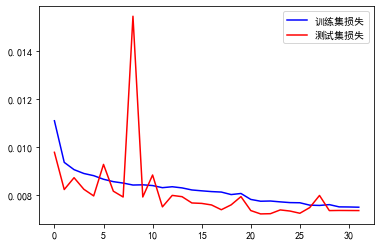

In [26]:
seed_everything()
#图像特征输入
image_input = keras.Input(shape=(5,64,64,3), name='image_input')

#文本特征输入
text_input = keras.Input(shape=(5,6), name='text_input')

#第一个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(32, kernel_size=(3,3), padding="same"))(image_input)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding="same"))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)

#第二个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(64, kernel_size=(3,3), padding="same"))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(SpatialPyramidPooling([1,2,3]))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

x = layers.Bidirectional(LSTM(units=32, activation='tanh'))(x)

#文本特征处理层
#第一个1DConv模块
x_ = layers.Conv1D(filters=32, kernel_size=3, padding='same',activation="relu")(text_input)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#第二个1DConv模块
x_ = layers.Conv1D(filters=64, kernel_size=3, padding='same',activation="relu")(x_)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#BiLSTM层+Attention
x_ = layers.Bidirectional(LSTM(units=32, activation='tanh',return_sequences=True))(x_)
x_ = Attention_block(x_)
x_ = layers.Flatten()(x_)

#合并图像和文本特征
output = layers.concatenate([x,x_])

#全连接层
output = layers.Dense(32, activation='relu')(output)

#输出层
output = layers.Dense(5)(output)

#创建模型
model = keras.Model(inputs=[image_input,text_input], outputs=output)
#编译模型
model.compile(optimizer="adam", loss='mse', metrics=['mae'])
#早停策略
early_stopping = EarlyStopping(
    monitor='val_loss',  # 监控的指标
    patience=10,         # 容忍的轮数
    restore_best_weights=True  # 恢复最好的权重
)
reduce_lr = LearningRateScheduler(scheduler)

filepath = "C:/Users/DELL/Desktop/2DTMM.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True, period=1)
#打印模型概述
model.summary()
reset_keras()
#训练模型
history =model.fit([X_train_image, X_train_text], y_train, batch_size=16, epochs=100, validation_data=([X_valid_image, X_valid_text], y_valid),callbacks=[reduce_lr,early_stopping, checkpoint])
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(loss)), loss, 'b-', label='训练集损失')
plt.plot(range(len(loss)), val_loss, 'r-', label='测试集损失')
plt.legend(loc='best')
plt.show()

# 模型加载

In [56]:
#2DTMM
#图像特征输入
image_input = keras.Input(shape=(5,64,64,3), name='image_input')

#文本特征输入
text_input = keras.Input(shape=(5,6), name='text_input')

#第一个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(32, kernel_size=(3,3), padding="same"))(image_input)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding="same"))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)

#第二个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(64, kernel_size=(3,3), padding="same"))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(SpatialPyramidPooling([1,2,3]))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.Bidirectional(LSTM(units=32, activation='tanh'))(x)

#文本特征处理层
#第一个1DConv模块
x_ = layers.Conv1D(filters=32, kernel_size=3, padding='same',activation="relu")(text_input)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#第二个1DConv模块
x_ = layers.Conv1D(filters=64, kernel_size=3, padding='same',activation="relu")(x_)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#BiLSTM层+Attention
x_ = layers.Bidirectional(LSTM(units=32, activation='tanh',return_sequences=True))(x_)
x_ = Attention_block(x_)
x_ = layers.Flatten()(x_)

#合并图像和文本特征
output = layers.concatenate([x,x_])

#全连接层
output = layers.Dense(32, activation='relu')(output)

#输出层
output = layers.Dense(5)(output)

#创建模型
model = keras.Model(inputs=[image_input,text_input], outputs=output)
model.load_weights(r"C:/Users/DELL/Desktop/2DTMM.h5")

In [64]:
#2DNormal
#图像特征输入
image_input = keras.Input(shape=(5,64,64,3), name='image_input')

#文本特征输入
text_input = keras.Input(shape=(5,6), name='text_input')

#第一个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(32, kernel_size=(3,3), padding="same"))(image_input)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding="same"))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)

#第二个3DCNN块
x = layers.TimeDistributed(layers.Conv2D(64, kernel_size=(3,3), padding="same"))(x)
x = layers.TimeDistributed(layers.BatchNormalization())(x)
x = layers.TimeDistributed(layers.Activation('relu'))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2), padding="same"))(x)
x = layers.TimeDistributed(layers.Dropout(0.25))(x)
x = layers.TimeDistributed(layers.Flatten())(x)
x = layers.Bidirectional(LSTM(units=32, activation='tanh'))(x)

#文本特征处理层
#第一个1DConv模块
x_ = layers.Conv1D(filters=32, kernel_size=3, padding='same',activation="relu")(text_input)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#第二个1DConv模块
x_ = layers.Conv1D(filters=64, kernel_size=3, padding='same',activation="relu")(x_)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#BiLSTM层+Attention
x_ = layers.Bidirectional(LSTM(units=32, activation='tanh',return_sequences=True))(x_)
x_ = Attention_block(x_)
x_ = layers.Flatten()(x_)

#合并图像和文本特征
output = layers.concatenate([x,x_])

#全连接层
output = layers.Dense(32, activation='relu')(output)

#输出层
output = layers.Dense(5)(output)

#创建模型
model = keras.Model(inputs=[image_input,text_input], outputs=output)
model.load_weights(r"C:/Users/DELL/Desktop/2DNormal.h5")

In [61]:
#Text
#文本特征输入
text_input = keras.Input(shape=(5,6), name='text_input')

#文本特征处理层
#第一个1DConv模块
x_ = layers.Conv1D(filters=32, kernel_size=3, padding='same',activation="relu")(text_input)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#第二个1DConv模块
x_ = layers.Conv1D(filters=64, kernel_size=3, padding='same',activation="relu")(x_)
x_ = layers.MaxPooling1D(pool_size=2, padding='same')(x_)
x_ = layers.Dropout(0.25)(x_)

#BiLSTM层+Attention
x_ = layers.Bidirectional(LSTM(units=32, activation='tanh',return_sequences=True))(x_)
x_ = Attention_block(x_)
x_ = layers.Flatten()(x_)

# 全连接层
output = layers.Dense(32, activation='relu')(x_)

# 输出层
output = layers.Dense(5)(output)

# 创建模型
model = keras.Model(inputs=text_input, outputs=output)
model.load_weights(r"C:/Users/DELL/Desktop/Text.h5")

In [65]:
reset_keras()
model_pred = model.predict([X_test_image, X_test_text])

24767
200/200 [==============================] - 5s 18ms/step


In [62]:
reset_keras()
model_pred = model.predict(X_test_text)

19181
200/200 [==============================] - 2s 7ms/step


In [60]:
#2DTMM
test_pred1 = model_pred * (file_max[5]-file_min[5])+file_min[5]
test_pred1=pd.DataFrame(test_pred1)
test_pred1=test_pred1*xtest
test_pred1

,0,1,2,3,4
0,45.682,46.829,55.231,56.057,55.677
1,44.118,45.469,54.639,55.495,55.467
2,45.744,47.971,58.256,59.341,60.091
3,48.960,52.900,63.914,65.375,67.442
4,55.056,60.162,71.538,73.471,76.757
...,...,...,...,...,...
6369,128.713,120.632,116.378,108.456,102.856
6370,121.753,113.995,109.891,102.246,96.846
6371,118.124,109.805,105.346,97.262,91.541
6372,112.021,103.469,98.834,90.298,84.283


In [66]:
#2DNormal
test_pred2 = model_pred * (file_max[5]-file_min[5])+file_min[5]
test_pred2=pd.DataFrame(test_pred2)
test_pred2=test_pred2*xtest
test_pred2

,0,1,2,3,4
0,43.505,45.991,49.618,53.050,55.937
1,44.887,47.521,51.121,54.461,57.077
2,46.850,49.606,53.237,56.529,59.033
3,48.089,50.965,54.539,57.667,59.956
4,51.168,54.136,57.887,61.177,63.562
...,...,...,...,...,...
6369,129.485,123.750,117.254,112.884,104.266
6370,120.641,115.169,108.849,104.249,95.846
6371,116.362,110.331,103.568,98.704,90.175
6372,105.826,100.448,94.272,89.491,81.511


In [63]:
#Text
test_pred3 = model_pred * (file_max[5]-file_min[5])+file_min[5]
test_pred3=pd.DataFrame(test_pred3)
test_pred3=test_pred3*xtest
test_pred3

,0,1,2,3,4
0,43.839,47.242,50.772,54.261,57.861
1,45.551,48.973,52.516,56.028,59.643
2,48.360,51.939,55.654,59.295,63.053
3,50.523,54.178,57.970,61.675,65.501
4,54.617,58.582,62.718,66.664,70.766
...,...,...,...,...,...
6369,134.200,128.766,122.764,116.713,112.059
6370,126.158,120.439,114.553,108.424,103.937
6371,122.419,115.200,108.590,101.944,96.827
6372,115.363,106.417,98.955,91.907,86.120


# 误差分析及可视化 

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 准备存储结果的列表
results = []

# 定义预测步长名称（根据您的实际步长修改）
step_names = ['2 min-ahead', '4 min-ahead', '6 min-ahead', '8 min-ahead', '10 min-ahead']

# 循环计算每个步长的指标
for i in range(5):  # 假设有5个预测步长
    # 获取真实值和预测值
    y_true = ytest_[i][:].values
    y_pred = test_pred1[i][:].values
  
    # 计算各项指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
  
    # 添加到结果列表
    results.append({
        'Prediction Step': step_names[i],
        'RMSE': rmse,
        'R²': r2
    })

# 创建DataFrame
results_df = pd.DataFrame(results)

# 设置索引为预测步长
results_df.set_index('Prediction Step', inplace=True)

# 格式化数值显示（保留3位小数）
pd.options.display.float_format = '{:.3f}'.format

# 打印表格
print("多步预测模型评估结果(2DTMM)")
print("="*50)
print(results_df)
print("="*50)

多步预测模型评估结果(2DTMM)
                   RMSE    R²
Prediction Step              
2 min-ahead      90.598 0.904
4 min-ahead     102.222 0.878
6 min-ahead     106.524 0.867
8 min-ahead     109.071 0.861
10 min-ahead    111.916 0.853


In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 准备存储结果的列表
results = []

# 定义预测步长名称（根据您的实际步长修改）
step_names = ['2 min-ahead', '4 min-ahead', '6 min-ahead', '8 min-ahead', '10 min-ahead']

# 循环计算每个步长的指标
for i in range(5):  # 假设有5个预测步长
    # 获取真实值和预测值
    y_true = ytest_[i][:].values
    y_pred = test_pred2[i][:].values
  
    # 计算各项指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
  
    # 添加到结果列表
    results.append({
        'Prediction Step': step_names[i],
        'RMSE': rmse,
        'R²': r2
    })

# 创建DataFrame
results_df = pd.DataFrame(results)

# 设置索引为预测步长
results_df.set_index('Prediction Step', inplace=True)

# 格式化数值显示（保留3位小数）
pd.options.display.float_format = '{:.3f}'.format

# 打印表格
print("多步预测模型评估结果(2DNormal)")
print("="*50)
print(results_df)
print("="*50)

多步预测模型评估结果(2DNormal)
                   RMSE    R²
Prediction Step              
2 min-ahead      94.035 0.896
4 min-ahead     106.206 0.868
6 min-ahead     111.093 0.855
8 min-ahead     113.686 0.849
10 min-ahead    116.659 0.841


In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 准备存储结果的列表
results = []

# 定义预测步长名称（根据您的实际步长修改）
step_names = ['2 min-ahead', '4 min-ahead', '6 min-ahead', '8 min-ahead', '10 min-ahead']

# 循环计算每个步长的指标
for i in range(5):  # 假设有5个预测步长
    # 获取真实值和预测值
    y_true = ytest_[i][:].values
    y_pred = test_pred3[i][:].values
  
    # 计算各项指标
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
  
    # 添加到结果列表
    results.append({
        'Prediction Step': step_names[i],
        'RMSE': rmse,
        'R²': r2
    })

# 创建DataFrame
results_df = pd.DataFrame(results)

# 设置索引为预测步长
results_df.set_index('Prediction Step', inplace=True)

# 格式化数值显示（保留3位小数）
pd.options.display.float_format = '{:.3f}'.format

# 打印表格
print("多步预测模型评估结果(Text)")
print("="*50)
print(results_df)
print("="*50)

多步预测模型评估结果(Text)
                   RMSE    R²
Prediction Step              
2 min-ahead      94.583 0.895
4 min-ahead     107.187 0.865
6 min-ahead     112.081 0.853
8 min-ahead     114.562 0.846
10 min-ahead    117.414 0.839


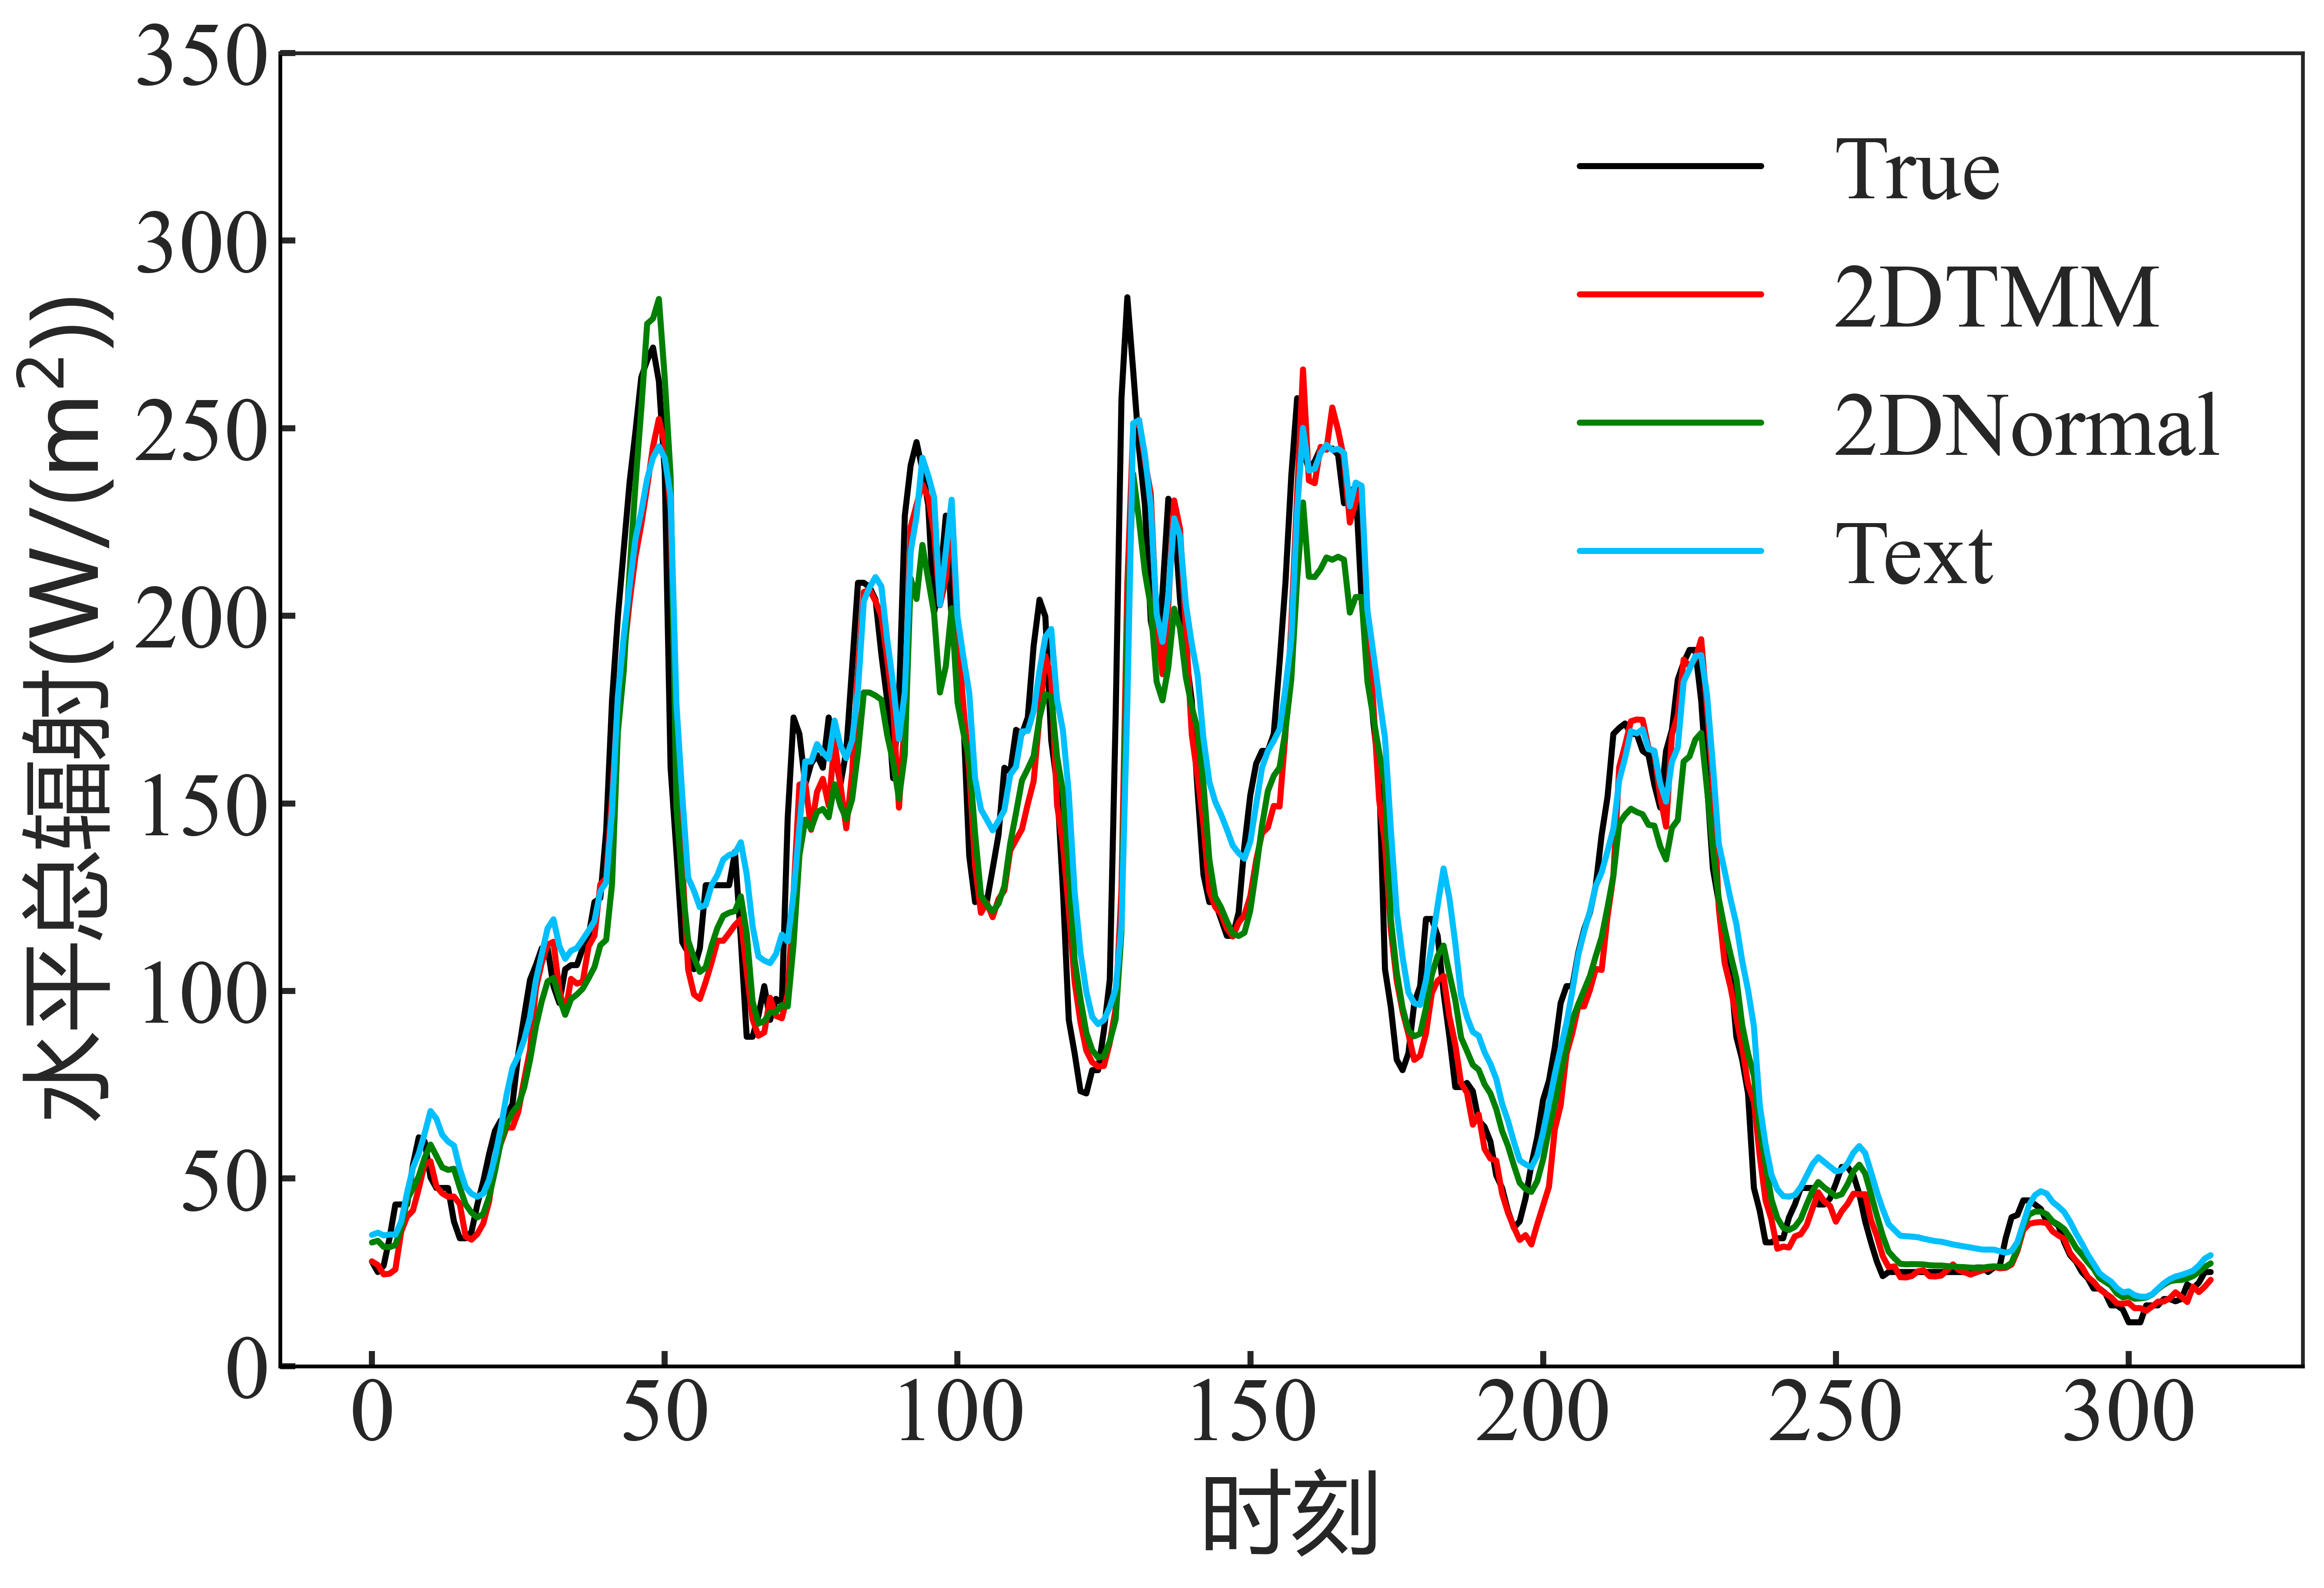

In [79]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#绘图
#plt.rc('font', family='Times New Roman')
plt.rc('font', family='Times New Roman')
fig, ax = plt.subplots(1, 1, figsize=(12, 8),dpi=500)
ax.tick_params(axis="both", which="major", direction="in", width=2, length=5)
plt.style.use('seaborn-white')  # 设置背景风格
plt.yticks(fontproperties = 'Times New Roman', size = 30)#18
plt.xticks(fontproperties = 'Times New Roman', size = 30)#18
plt.xlabel('时刻', fontsize=30,fontproperties="Microsoft YaHei")#18
plt.ylabel('水平总辐射(W/(m$^{2}$))', fontsize=30,fontproperties="Microsoft YaHei")#18
ax.set_ylim(0,350)
ax.plot(np.array(ytest_[0][320*14+35:320*15+30]), color='black', linestyle='solid', linewidth=2)
ax.plot(np.array(test_pred1[0][320*14+35:320*15+30]), color='red', linestyle='-', linewidth=2)
ax.plot(np.array(test_pred2[0][320*14+35:320*15+30]), color='green', linestyle='-', linewidth=2)
ax.plot(np.array(test_pred3[0][320*14+35:320*15+30]), color='deepskyblue', linestyle='-', linewidth=2)
font = {'family': 'Times New Roman','size': 30,}#18
plt.legend(["True","2DTMM","2DNormal","Text"], ncol=1,loc='upper right',prop=font)

#更改框架颜色
ax.spines['bottom'].set_edgecolor('black')
ax.spines['left'].set_edgecolor('black')

#显示
plt.show()